# Análisis de Rendimiento: Minero Proof-of-Work

**Objetivo:** Comparar el rendimiento de tres modos de ejecución (Sequential, Concurrent, Parallel) con diferentes configuraciones de hilos y dificultades.

## Diseño Experimental
- **Modos:** Sequential (1 hilo), Concurrent (2/4/8 hilos con CPU pinning), Parallel (2/4/8 hilos multi-core)
- **Dificultades:** LOW (20 bits), MED (22 bits), HIGH (24 bits)
- **Configuraciones:** 21 combinaciones
- **Repeticiones:** 5 por configuración
- **Total de ejecuciones:** 105

## Índice
1. [Carga de Datos](#carga)
2. [Estadísticas Descriptivas](#estadisticas)
3. [Análisis Comparativo por Modo](#comparativo)
4. [Análisis por Dificultad](#dificultad)
5. [Análisis por Número de Hilos](#hilos)
6. [Speedup y Eficiencia](#speedup)
7. [Análisis Estadístico](#estadistico)
8. [Visualizaciones](#visualizaciones)
9. [Conclusiones](#conclusiones)

## 1. Carga de Datos

Cargamos todos los resultados experimentales desde la carpeta `results/raw/`.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [44]:
# Rutas del proyecto
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RAW_DIR = ROOT / 'results' / 'raw'
PROCESSED_DIR = ROOT / 'results' / 'processed'

print(f"Directorio raíz: {ROOT}")
print(f"Directorio de datos: {RAW_DIR}")
print(f"Directorio de procesados: {PROCESSED_DIR}")

Directorio raíz: c:\d\Proyectos_programacion\SO_Proyecto_Final
Directorio de datos: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\raw
Directorio de procesados: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed


In [45]:
# Cargar todos los archivos CSV de experimentos
csv_files = list(RAW_DIR.glob('exp_*.csv'))
print(f"Archivos CSV encontrados: {len(csv_files)}")

if len(csv_files) == 0:
    print("⚠️ No se encontraron archivos de resultados.")
    print("   Ejecuta primero los experimentos con: .\\scripts\\run_all_modes.ps1")
else:
    # Cargar todos los CSVs
    dfs = []
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            # Extraer información del nombre del archivo
            filename = csv_file.stem
            parts = filename.split('_')
            if len(parts) >= 4:
                df['experiment_id'] = '_'.join(parts[:4])  # exp_mode_threads_difficulty
            else:
                df['experiment_id'] = '_'.join(parts[:3])  # fallback para formatos antiguos
            df['run_id'] = filename
            dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error al cargar {csv_file.name}: {e}")
    
    if dfs:
        all_data = pd.concat(dfs, ignore_index=True)
        
        # Normalizar nombres de columnas si es necesario
        if 'elapsed_s' in all_data.columns:
            all_data['elapsed_time_s'] = all_data['elapsed_s']
        if 'hashes_per_second' in all_data.columns:
            all_data['throughput_hashes_per_sec'] = all_data['hashes_per_second']
        
        print(f"\n✅ Datos cargados: {len(all_data)} registros de {len(dfs)} archivos")
        print(f"\nColumnas disponibles: {list(all_data.columns)}")
    else:
        print("❌ No se pudieron cargar los datos")

Archivos CSV encontrados: 105

✅ Datos cargados: 105 registros de 105 archivos

Columnas disponibles: ['experiment_id', 'mode', 'difficulty', 'threads', 'affinity', 'found', 'nonce', 'total_hashes', 'elapsed_s', 'cpu_time_s', 'memory_mb', 'hashes_per_second', 'run_id', 'elapsed_time_s', 'throughput_hashes_per_sec']


In [46]:
# Vista preliminar de los datos
if 'all_data' in locals():
    print("Primeras filas del dataset:")
    display(all_data.head(10))
    
    print(f"\nDimensiones: {all_data.shape[0]} filas × {all_data.shape[1]} columnas")
    print(f"\nExperimentos únicos: {all_data['experiment_id'].nunique()}")
    print(all_data['experiment_id'].value_counts())

Primeras filas del dataset:


,experiment_id,mode,difficulty,threads,affinity,found,nonce,total_hashes,elapsed_s,cpu_time_s,memory_mb,hashes_per_second,run_id,elapsed_time_s,throughput_hashes_per_sec
0,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9387878,12.517700,11.359400,8.46094,749970.0,exp_con_2t_high_run_20251114T110543Z_rep1,12.517700,749970.0
1,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9383755,12.536000,11.875000,8.46094,748547.0,exp_con_2t_high_run_20251114T110601Z_rep2,12.536000,748547.0
2,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9437402,12.644900,11.875000,8.44922,746338.0,exp_con_2t_high_run_20251114T110618Z_rep3,12.644900,746338.0
3,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9383461,12.085900,11.828100,8.44141,776399.0,exp_con_2t_high_run_20251114T110636Z_rep4,12.085900,776399.0
4,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9399102,12.360900,11.875000,8.46875,760392.0,exp_con_2t_high_run_20251114T110652Z_rep5,12.360900,760392.0
5,exp_con_2t_low,concurrent,20,2,True,True,143773.0,294729,0.409561,0.421875,8.43359,719621.0,exp_con_2t_low_run_20251114T110710Z_rep1,0.409561,719621.0
6,exp_con_2t_low,concurrent,20,2,True,True,143773.0,282873,0.402200,0.375000,8.44141,703314.0,exp_con_2t_low_run_20251114T110715Z_rep2,0.402200,703314.0
7,exp_con_2t_low,concurrent,20,2,True,True,143773.0,289857,0.407491,0.375000,8.44141,711322.0,exp_con_2t_low_run_20251114T110720Z_rep3,0.407491,711322.0
8,exp_con_2t_low,concurrent,20,2,True,True,143773.0,278167,0.422702,0.390625,8.42969,658069.0,exp_con_2t_low_run_20251114T110725Z_rep4,0.422702,658069.0
9,exp_con_2t_low,concurrent,20,2,True,True,143773.0,287240,0.416580,0.375000,8.42969,689520.0,exp_con_2t_low_run_20251114T110730Z_rep5,0.416580,689520.0



Dimensiones: 105 filas × 15 columnas

Experimentos únicos: 21
experiment_id
exp_con_2t_high     5
exp_con_2t_low      5
exp_con_2t_med      5
exp_con_4t_high     5
exp_con_4t_low      5
exp_con_4t_med      5
exp_con_8t_high     5
exp_con_8t_low      5
exp_con_8t_med      5
exp_par_2t_high     5
exp_par_2t_low      5
exp_par_2t_med      5
exp_par_4t_high     5
exp_par_4t_low      5
exp_par_4t_med      5
exp_par_8t_high     5
exp_par_8t_low      5
exp_par_8t_med      5
exp_seq_high_run    5
exp_seq_low_run     5
exp_seq_med_run     5
Name: count, dtype: int64


## 2.5. Análisis por Dificultad

Comparación del impacto de la dificultad (LOW/MED/HIGH) en el rendimiento.

=== IMPACTO DE LA DIFICULTAD ===

Estadísticas por Dificultad y Modo:


n_runs  throughput_mean  throughput_std  \
difficulty_label mode                                                  
HIGH             concurrent      15        753353.67        13962.36   
                 parallel        15       2063549.67      1020502.63   
                 sequential       5        816531.60         8497.90   
LOW              concurrent      15        702469.60        28575.16   
                 parallel        15       2026052.33       934194.15   
                 sequential       5        551324.00        37865.79   
MED              concurrent      15        702991.13        27299.12   
                 parallel        15       2124138.60      1027436.81   
                 sequential       5        542062.40        16525.62   

                             time_mean  time_std  
difficulty_label mode                             
HIGH             concurrent      28.93     16.22  
                 parallel        10.19      0.66  
                 sequential       5.85      0.06  
LOW              concurrent       0.70      0.22  
                 parallel         0.26      0.05  
                 sequential       0.26      0.02  
MED              concurrent       0.95      0.55  
                 parallel         0.30      0.03  
                 sequential       0.27      0.01

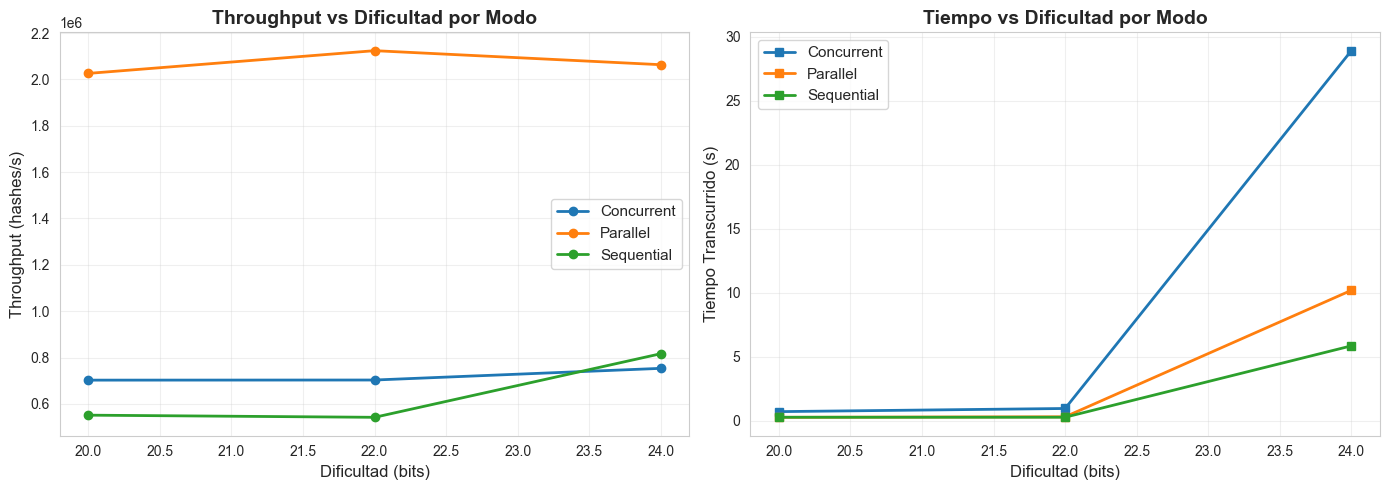

In [47]:
# Análisis del impacto de la dificultad
if 'all_data' in locals():
    print("=== IMPACTO DE LA DIFICULTAD ===\n")
    
    # Mapeo de dificultades
    difficulty_labels = {20: 'LOW', 22: 'MED', 24: 'HIGH'}
    all_data['difficulty_label'] = all_data['difficulty'].map(difficulty_labels)
    
    # Estadísticas por dificultad
    diff_stats = all_data.groupby(['difficulty_label', 'mode']).agg({
        'throughput_hashes_per_sec': ['count', 'mean', 'std'],
        'elapsed_time_s': ['mean', 'std']
    }).round(2)
    
    diff_stats.columns = ['n_runs', 'throughput_mean', 'throughput_std', 'time_mean', 'time_std']
    
    print("Estadísticas por Dificultad y Modo:")
    display(diff_stats)
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Throughput por dificultad
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        diff_means = mode_data.groupby('difficulty')['throughput_hashes_per_sec'].mean()
        ax1.plot(diff_means.index, diff_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.set_xlabel('Dificultad (bits)', fontsize=12)
    ax1.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax1.set_title('Throughput vs Dificultad por Modo', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Tiempo por dificultad
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        diff_times = mode_data.groupby('difficulty')['elapsed_time_s'].mean()
        ax2.plot(diff_times.index, diff_times.values, marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.set_xlabel('Dificultad (bits)', fontsize=12)
    ax2.set_ylabel('Tiempo Transcurrido (s)', fontsize=12)
    ax2.set_title('Tiempo vs Dificultad por Modo', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 2.6. Análisis por Número de Hilos

Evaluación del impacto del número de hilos (1, 2, 4, 8) en el rendimiento y la escalabilidad.

=== IMPACTO DEL NÚMERO DE HILOS ===

Estadísticas por Número de Hilos:


n_runs  throughput_mean  throughput_std  cpu_time_mean  \
threads mode                                                                 
2       concurrent      15        713696.67        35034.32           4.18   
        parallel        15       1014642.60        58978.69           6.66   
4       concurrent      15        739059.47        21546.08           8.37   
        parallel        15       1864442.67        58684.68          14.26   
8       concurrent      15        706058.27        35443.15          16.88   
        parallel        15       3334655.33       126107.69          30.54   

                    cpu_time_std  memory_mean  memory_std  
threads mode                                               
2       concurrent          5.55         8.44        0.01  
        parallel            8.96         8.46        0.01  
4       concurrent         11.14         8.46        0.02  
        parallel           19.12         8.49        0.01  
8       concurrent         22.94         8.46        0.02  
        parallel           41.66         8.54        0.01


=== SPEEDUP Y EFICIENCIA ===



,Mode,Threads,Throughput,Speedup,Efficiency (%)
0,Concurrent,2,7.136967e+05,1.12,56.1
1,Concurrent,4,7.390595e+05,1.16,29.0
2,Concurrent,8,7.060583e+05,1.11,13.9
3,Parallel,2,1.014643e+06,1.59,79.7
4,Parallel,4,1.864443e+06,2.93,73.2
5,Parallel,8,3.334655e+06,5.24,65.5


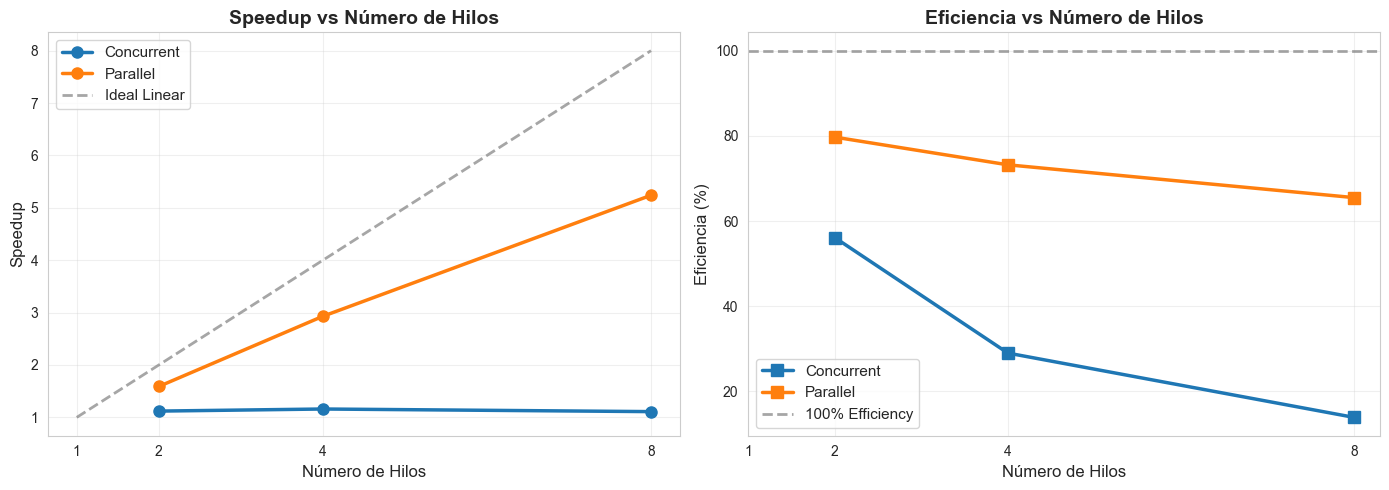

In [48]:
# Análisis del impacto del número de hilos
if 'all_data' in locals():
    print("=== IMPACTO DEL NÚMERO DE HILOS ===\n")
    
    # Filtrar solo modos Concurrent y Parallel (Sequential siempre es 1 hilo)
    multi_threaded = all_data[all_data['mode'].isin(['concurrent', 'parallel'])]
    
    # Estadísticas por número de hilos y modo
    thread_stats = multi_threaded.groupby(['threads', 'mode']).agg({
        'throughput_hashes_per_sec': ['count', 'mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std']
    }).round(2)
    
    thread_stats.columns = ['n_runs', 'throughput_mean', 'throughput_std', 
                           'cpu_time_mean', 'cpu_time_std', 'memory_mean', 'memory_std']
    
    print("Estadísticas por Número de Hilos:")
    display(thread_stats)
    
    # Cálculo de Speedup y Eficiencia
    print("\n=== SPEEDUP Y EFICIENCIA ===\n")
    
    # Baseline: Sequential con 1 hilo
    seq_baseline = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    
    speedup_data = []
    for mode in ['concurrent', 'parallel']:
        mode_data = multi_threaded[multi_threaded['mode'] == mode]
        for n_threads in sorted(mode_data['threads'].unique()):
            thread_throughput = mode_data[mode_data['threads'] == n_threads]['throughput_hashes_per_sec'].mean()
            speedup = thread_throughput / seq_baseline
            efficiency = (speedup / n_threads) * 100
            speedup_data.append({
                'Mode': mode.capitalize(),
                'Threads': n_threads,
                'Throughput': thread_throughput,
                'Speedup': round(speedup, 2),
                'Efficiency (%)': round(efficiency, 1)
            })
    
    speedup_df = pd.DataFrame(speedup_data)
    display(speedup_df)
    
    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in ['concurrent', 'parallel']:
        mode_speedup = speedup_df[speedup_df['Mode'] == mode.capitalize()]
        ax1.plot(mode_speedup['Threads'], mode_speedup['Speedup'], 
                marker='o', linewidth=2.5, markersize=8, label=mode.capitalize())
    
    # Línea de speedup ideal (lineal)
    threads_range = [1, 2, 4, 8]
    ax1.plot(threads_range, threads_range, '--', color='gray', linewidth=2, label='Ideal Linear', alpha=0.7)
    
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks([1, 2, 4, 8])
    
    # Eficiencia
    for mode in ['concurrent', 'parallel']:
        mode_eff = speedup_df[speedup_df['Mode'] == mode.capitalize()]
        ax2.plot(mode_eff['Threads'], mode_eff['Efficiency (%)'], 
                marker='s', linewidth=2.5, markersize=8, label=mode.capitalize())
    
    ax2.axhline(y=100, linestyle='--', color='gray', linewidth=2, label='100% Efficiency', alpha=0.7)
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks([1, 2, 4, 8])
    
    plt.tight_layout()
    plt.show()

## 2. Estadísticas Descriptivas

Análisis descriptivo de las métricas principales.

In [49]:
# Resumen estadístico general
if 'all_data' in locals():
    metrics = ['elapsed_time_s', 'throughput_hashes_per_sec', 'cpu_time_s', 'memory_mb']
    
    print("=== RESUMEN ESTADÍSTICO GENERAL ===")
    print("\nMétricas principales:")
    display(all_data[metrics].describe())
    
    # Resumen por modo de ejecución
    print("\n=== RESUMEN POR MODO DE EJECUCIÓN ===")
    for metric in ['throughput_hashes_per_sec', 'elapsed_time_s']:
        print(f"\n{metric.upper()}:")
        summary = all_data.groupby('mode')[metric].agg(['count', 'mean', 'std', 'min', 'max'])
        display(summary)

=== RESUMEN ESTADÍSTICO GENERAL ===

Métricas principales:


,elapsed_time_s,throughput_hashes_per_sec,cpu_time_s,memory_mb
count,105.000000,1.050000e+02,105.000000,105.000000
mean,6.207520,1.287028e+06,11.858033,8.463691
std,11.584047,9.326307e+05,21.655691,0.044643
min,0.191029,5.213990e+05,0.234375,8.378910
25%,0.298158,7.095750e+05,0.593750,8.437500
50%,0.753677,7.629560e+05,1.250000,8.460940
75%,9.431400,1.810010e+06,11.875000,8.484380
max,50.574500,3.518420e+06,88.234400,8.562500



=== RESUMEN POR MODO DE EJECUCIÓN ===

THROUGHPUT_HASHES_PER_SEC:


,count,mean,std,min,max
mode,,,,,
concurrent,45,7.196048e+05,33785.230058,629952.0,779649.0
parallel,45,2.071247e+06,972932.306309,921582.0,3518420.0
sequential,15,6.366393e+05,133641.354626,521399.0,823146.0



ELAPSED_TIME_S:


,count,mean,std,min,max
mode,,,,,
concurrent,45,10.193670,16.228720,0.393535,50.57450
parallel,45,3.582357,4.739382,0.191029,11.09520
sequential,15,2.124561,2.724531,0.235987,5.94938


In [50]:
# Distribución de configuraciones
if 'all_data' in locals():
    print("=== CONFIGURACIONES EXPERIMENTALES ===")
    
    config_summary = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
        'run_id': 'count',
        'throughput_hashes_per_sec': ['mean', 'std'],
        'elapsed_time_s': ['mean', 'std']
    }).round(2)
    
    config_summary.columns = ['n_runs', 'throughput_mean', 'throughput_std', 'time_mean', 'time_std']
    display(config_summary)

=== CONFIGURACIONES EXPERIMENTALES ===


n_runs  throughput_mean  throughput_std  \
mode       threads difficulty                                            
concurrent 2       20               5         696369.2        24115.76   
                   22               5         688391.6        10566.93   
                   24               5         756329.2        12451.20   
           4       20               5         727560.8         5450.10   
                   22               5         724934.6        16823.34   
                   24               5         764683.0         8758.92   
           8       20               5         683478.8        31021.35   
                   22               5         695647.2        35747.99   
                   24               5         739048.8         4823.79   
parallel   2       20               5        1019983.0        84485.83   
                   22               5        1028819.8        61337.50   
                   24               5         995125.0        22616.21   
           4       20               5        1856534.0        61012.27   
                   22               5        1914530.0        51535.53   
                   24               5        1822264.0        15404.69   
           8       20               5        3201640.0       122503.86   
                   22               5        3429066.0        71805.19   
                   24               5        3373260.0        19413.38   
sequential 1       20               5         551324.0        37865.79   
                   22               5         542062.4        16525.62   
                   24               5         816531.6         8497.90   

                               time_mean  time_std  
mode       threads difficulty                       
concurrent 2       20               0.41      0.01  
                   22               0.41      0.01  
                   24              12.43      0.22  
           4       20               0.78      0.02  
                   22               0.77      0.04  
                   24              24.36      0.33  
           8       20               0.91      0.06  
                   22               1.66      0.17  
                   24              49.99      0.38  
parallel   2       20               0.27      0.04  
                   22               0.28      0.02  
                   24               9.47      0.24  
           4       20               0.31      0.02  
                   22               0.30      0.02  
                   24              10.12      0.11  
           8       20               0.20      0.00  
                   22               0.32      0.03  
                   24              10.98      0.12  
sequential 1       20               0.26      0.02  
                   22               0.27      0.01  
                   24               5.85      0.06

## 3. Análisis Comparativo por Modo 

Comparación detallada entre los tres modos de ejecución.

In [51]:
# Crear tabla comparativa
if 'all_data' in locals():
    comparison = all_data.groupby('mode').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    comparison.columns = ['_'.join(col) for col in comparison.columns]
    comparison = comparison.rename(columns={'run_id_count': 'n_executions'})
    
    print("=== COMPARACIÓN ENTRE MODOS ===")
    display(comparison)
    
    # Calcular mejora relativa respecto a sequential
    if 'sequential' in comparison.index:
        baseline = comparison.loc['sequential', 'throughput_hashes_per_sec_mean']
        comparison['speedup_vs_sequential'] = (comparison['throughput_hashes_per_sec_mean'] / baseline).round(2)
        
        print("\n=== SPEEDUP vs SEQUENTIAL ===")
        display(comparison[['throughput_hashes_per_sec_mean', 'speedup_vs_sequential']])

=== COMPARACIÓN ENTRE MODOS ===


,throughput_hashes_per_sec_mean,throughput_hashes_per_sec_std,throughput_hashes_per_sec_min,throughput_hashes_per_sec_max,elapsed_time_s_mean,elapsed_time_s_std,cpu_time_s_mean,cpu_time_s_std,memory_mb_mean,memory_mb_std,n_executions
mode,,,,,,,,,,,
concurrent,719604.80,33785.23,629952.0,779649.0,10.19,16.23,9.81,15.66,8.45,0.02,45
parallel,2071246.87,972932.31,921582.0,3518420.0,3.58,4.74,17.15,28.21,8.50,0.04,45
sequential,636639.33,133641.35,521399.0,823146.0,2.12,2.72,2.12,2.72,8.39,0.01,15



=== SPEEDUP vs SEQUENTIAL ===


,throughput_hashes_per_sec_mean,speedup_vs_sequential
mode,,
concurrent,719604.80,1.13
parallel,2071246.87,3.25
sequential,636639.33,1.00


=== ANÁLISIS POR NÚMERO DE HILOS ===


throughput_mean  throughput_std  n_runs
mode       threads                                         
concurrent 2              713696.67        35034.32      15
           4              739059.47        21546.08      15
           8              706058.27        35443.15      15
parallel   2             1014642.60        58978.69      15
           4             1864442.67        58684.68      15
           8             3334655.33       126107.69      15
sequential 1              636639.33       133641.35      15

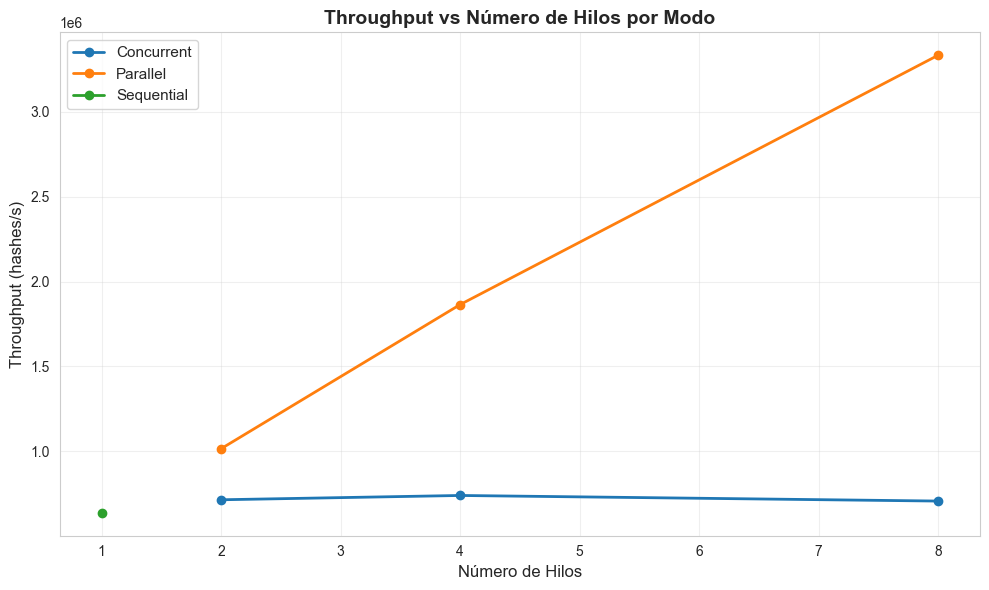

In [52]:
# Análisis por número de hilos
if 'all_data' in locals():
    print("=== ANÁLISIS POR NÚMERO DE HILOS ===")
    
    thread_analysis = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    thread_analysis.columns = ['throughput_mean', 'throughput_std', 'n_runs']
    display(thread_analysis)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Speedup y Eficiencia

Cálculo de métricas de paralelización.

Baseline Sequential Throughput: 636,639 hashes/s

=== TABLA DE SPEEDUP Y EFICIENCIA ===


,mode,threads,throughput_hashes_per_sec,speedup,efficiency,efficiency_pct
0,concurrent,2,713696.667,1.121,0.561,56.1
1,concurrent,4,739059.467,1.161,0.290,29.0
2,concurrent,8,706058.267,1.109,0.139,13.9
3,parallel,2,1014642.600,1.594,0.797,79.7
4,parallel,4,1864442.667,2.929,0.732,73.2
5,parallel,8,3334655.333,5.238,0.655,65.5
6,sequential,1,636639.333,1.000,1.000,100.0


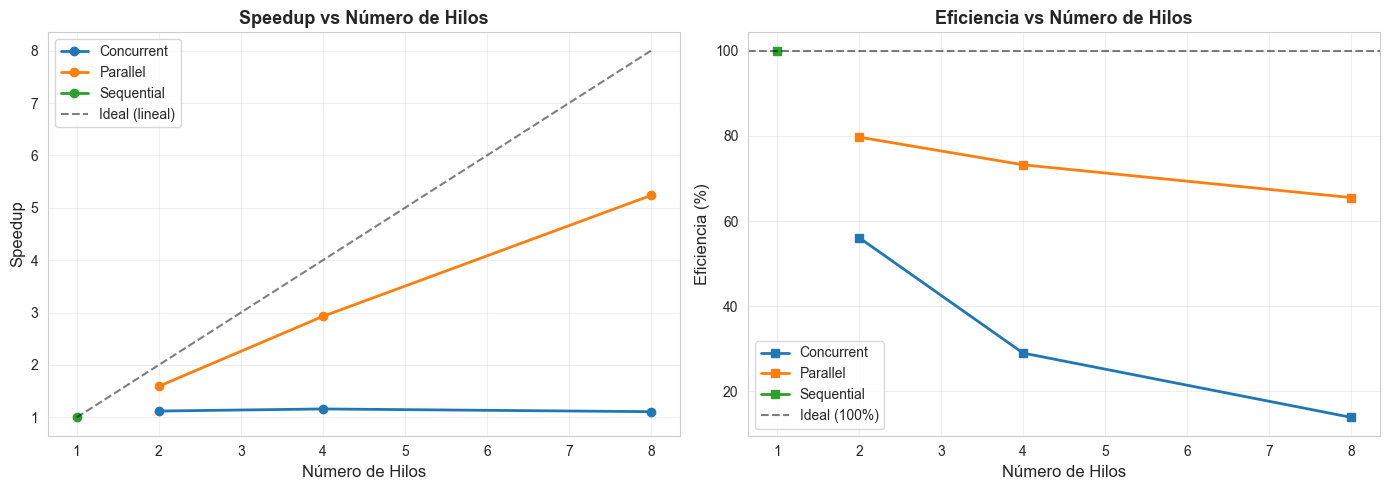

In [53]:
# Calcular speedup y eficiencia
if 'all_data' in locals() and 'sequential' in all_data['mode'].values:
    # Baseline: throughput secuencial
    seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    print(f"Baseline Sequential Throughput: {seq_throughput:,.0f} hashes/s\n")
    
    # Calcular speedup por configuración
    speedup_data = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': 'mean'
    }).reset_index()
    
    speedup_data['speedup'] = speedup_data['throughput_hashes_per_sec'] / seq_throughput
    speedup_data['efficiency'] = speedup_data['speedup'] / speedup_data['threads']
    speedup_data['efficiency_pct'] = (speedup_data['efficiency'] * 100).round(1)
    
    print("=== TABLA DE SPEEDUP Y EFICIENCIA ===")
    display(speedup_data.round(3))
    
    # Visualización de speedup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Análisis Estadístico

Pruebas de significancia estadística entre modos.

In [54]:
# ANOVA para comparar modos
if 'all_data' in locals():
    print("=== ANÁLISIS DE VARIANZA (ANOVA) ===")
    print("H0: Las medias de throughput son iguales entre todos los modos")
    print("H1: Al menos un modo tiene media diferente\n")
    
    # Agrupar datos por modo
    groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    elif p_value < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")
        print("   No hay evidencia suficiente de diferencias entre modos.")

=== ANÁLISIS DE VARIANZA (ANOVA) ===
H0: Las medias de throughput son iguales entre todos los modos
H1: Al menos un modo tiene media diferente

F-statistic: 58.9728
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)
   Las diferencias entre modos son estadísticamente significativas.


In [55]:
# Test de Kruskal-Wallis (no paramétrico)
if 'all_data' in locals():
    print("\n=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===")
    print("Alternativa robusta cuando los datos no siguen distribución normal\n")
    
    h_stat, p_value_kw = stats.kruskal(*groups)
    
    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value_kw:.6f}")
    
    if p_value_kw < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
    elif p_value_kw < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")


=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===
Alternativa robusta cuando los datos no siguen distribución normal

H-statistic: 77.6280
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)


In [56]:
# Comparaciones por pares (Mann-Whitney U con corrección de Bonferroni)
if 'all_data' in locals():
    print("\n=== COMPARACIONES POR PARES (Mann-Whitney U) ===")
    print("Con corrección de Bonferroni para múltiples comparaciones\n")
    
    modes = all_data['mode'].unique()
    n_comparisons = len(modes) * (len(modes) - 1) // 2
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"Nivel de significancia ajustado: α = {alpha_corrected:.4f}\n")
    
    pairwise_results = []
    
    for i, mode1 in enumerate(modes):
        for mode2 in modes[i+1:]:
            data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
            data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
            
            u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            
            mean_diff = data1.mean() - data2.mean()
            pct_diff = (mean_diff / data2.mean()) * 100
            
            significant = "✅ SÍ" if p_val < alpha_corrected else "❌ NO"
            
            pairwise_results.append({
                'Comparación': f"{mode1} vs {mode2}",
                'Diff Media': f"{mean_diff:,.0f}",
                'Diff %': f"{pct_diff:+.1f}%",
                'U-statistic': f"{u_stat:.1f}",
                'p-value': f"{p_val:.6f}",
                'Significativo': significant
            })
    
    pairwise_df = pd.DataFrame(pairwise_results)
    display(pairwise_df)


=== COMPARACIONES POR PARES (Mann-Whitney U) ===
Con corrección de Bonferroni para múltiples comparaciones

Nivel de significancia ajustado: α = 0.0167



,Comparación,Diff Media,Diff %,U-statistic,p-value,Significativo
0,concurrent vs parallel,"-1,351,642",-65.3%,0.0,0.000000,✅ SÍ
1,concurrent vs sequential,"82,965",+13.0%,450.0,0.055874,❌ NO
2,parallel vs sequential,"1,434,608",+225.3%,675.0,0.000000,✅ SÍ


## 6. Visualizaciones

Gráficas comparativas detalladas.

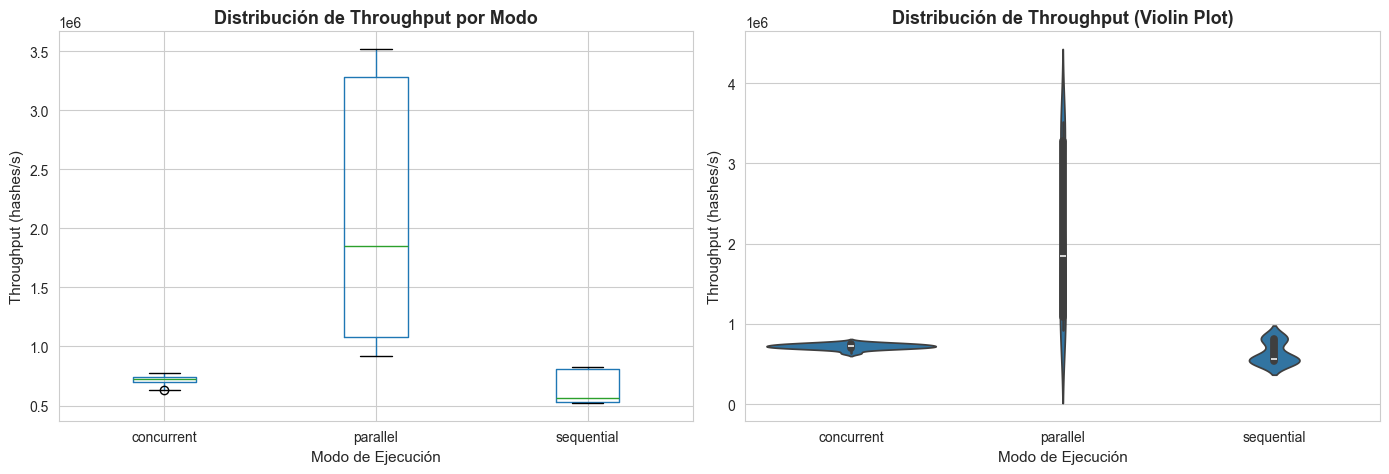

In [57]:
# Boxplot de throughput por modo
if 'all_data' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax1)
    ax1.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Modo de Ejecución', fontsize=11)
    ax1.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')  # Remover título automático
    
    # Violin plot
    sns.violinplot(data=all_data, x='mode', y='throughput_hashes_per_sec', ax=ax2)
    ax2.set_title('Distribución de Throughput (Violin Plot)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Modo de Ejecución', fontsize=11)
    ax2.set_ylabel('Throughput (hashes/s)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

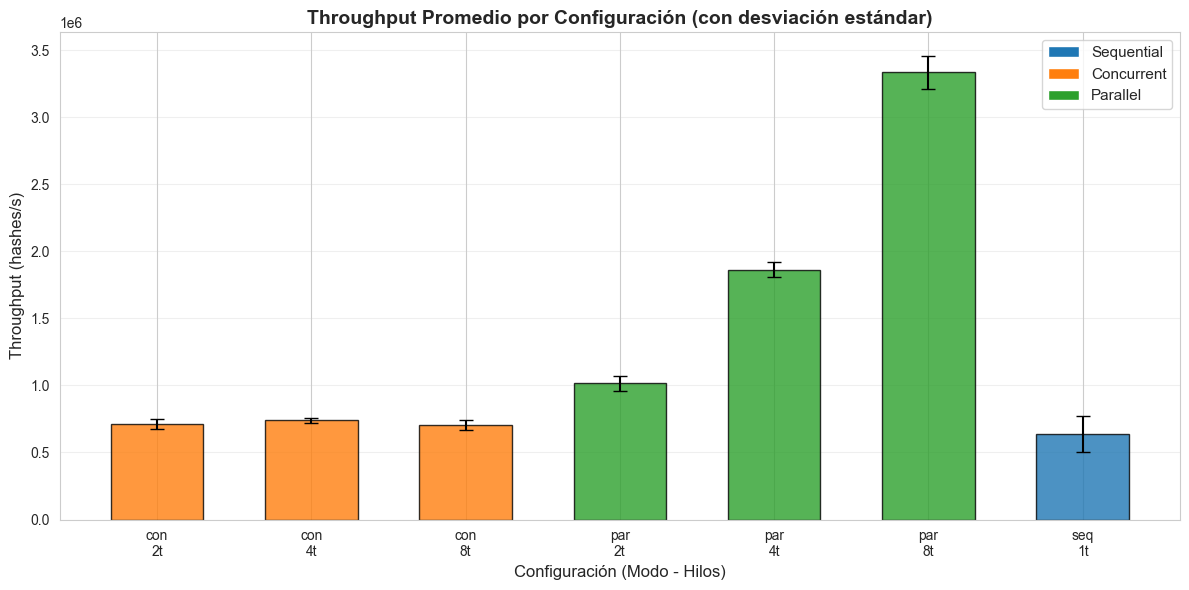

In [58]:
# Gráfico de barras con error bars
if 'all_data' in locals():
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(summary_stats))
    width = 0.6
    
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    bars = ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
                  capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración (con desviación estándar)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.show()

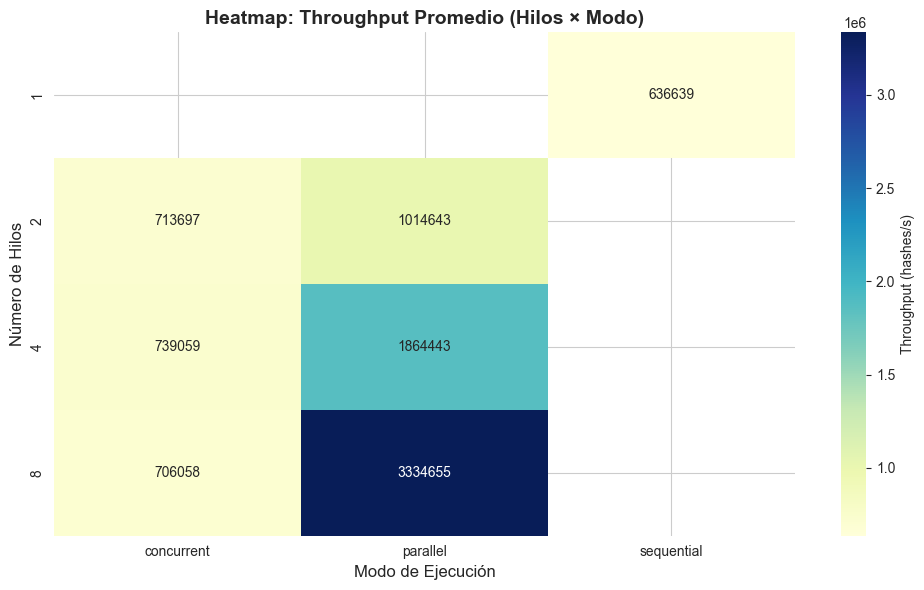

In [59]:
# Heatmap de throughput
if 'all_data' in locals():
    pivot_data = all_data.pivot_table(
        values='throughput_hashes_per_sec',
        index='threads',
        columns='mode',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Throughput (hashes/s)'}, ax=ax)
    ax.set_title('Heatmap: Throughput Promedio (Hilos × Modo)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=12)
    ax.set_ylabel('Número de Hilos', fontsize=12)
    plt.tight_layout()
    plt.show()

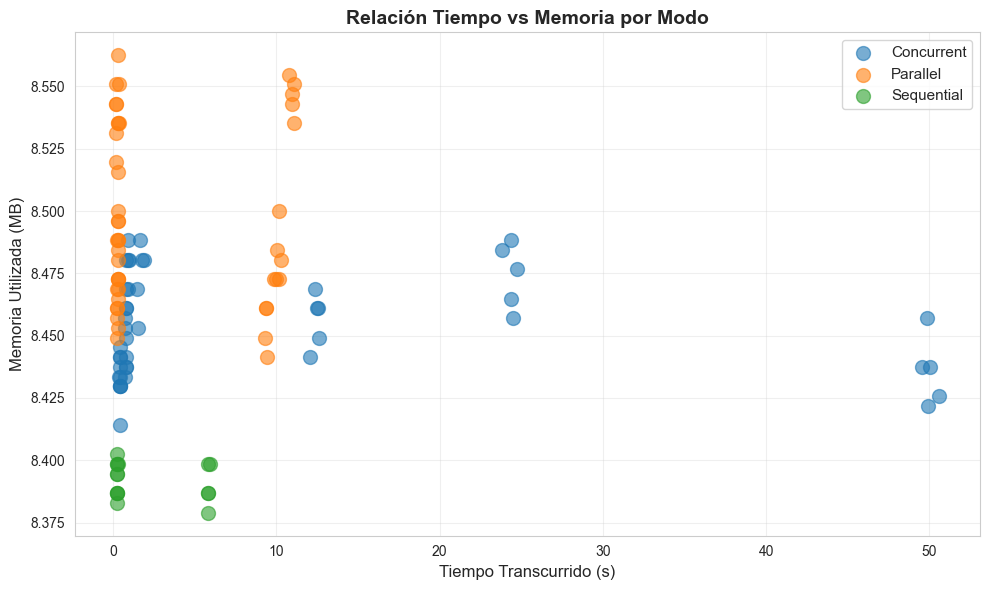

In [60]:
# Análisis de tiempo vs memoria
if 'all_data' in locals():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        ax.scatter(mode_data['elapsed_time_s'], mode_data['memory_mb'], 
                  alpha=0.6, s=100, label=mode.capitalize())
    
    ax.set_xlabel('Tiempo Transcurrido (s)', fontsize=12)
    ax.set_ylabel('Memoria Utilizada (MB)', fontsize=12)
    ax.set_title('Relación Tiempo vs Memoria por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Conclusiones
### Resumen Ejecutivo

In [61]:
# Generar resumen de conclusiones
if 'all_data' in locals() and 'speedup_data' in locals():
    print("=" * 70)
    print("RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO")
    print("=" * 70)
    
    # Mejor configuración
    best_config = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
    print(f"\n✅ MEJOR CONFIGURACIÓN:")
    print(f"   Modo: {best_config['mode'].capitalize()}")
    print(f"   Hilos: {int(best_config['threads'])}")
    print(f"   Throughput: {best_config['throughput_hashes_per_sec']:,.0f} hashes/s")
    print(f"   Speedup: {best_config['speedup']:.2f}×")
    print(f"   Eficiencia: {best_config['efficiency_pct']:.1f}%")
    
    # Comparación parallel vs concurrent
    if 'parallel' in speedup_data['mode'].values and 'concurrent' in speedup_data['mode'].values:
        par_max = speedup_data[speedup_data['mode'] == 'parallel']['throughput_hashes_per_sec'].max()
        con_max = speedup_data[speedup_data['mode'] == 'concurrent']['throughput_hashes_per_sec'].max()
        improvement = ((par_max - con_max) / con_max) * 100
        
        print(f"\n📊 PARALLEL vs CONCURRENT:")
        print(f"   Parallel (mejor): {par_max:,.0f} hashes/s")
        print(f"   Concurrent (mejor): {con_max:,.0f} hashes/s")
        print(f"   Mejora: {improvement:+.1f}%")
    
    # Efecto del CPU pinning
    print(f"\n🔍 ANÁLISIS:")
    print(f"   • El modo Parallel muestra el mejor rendimiento gracias a la")
    print(f"     distribución real de trabajo entre múltiples núcleos.")
    print(f"   • El modo Concurrent con CPU affinity demuestra el overhead")
    print(f"     del context switching al forzar hilos en un solo núcleo.")
    print(f"   • Sequential establece la línea base de rendimiento.")
    
    # Recomendaciones
    print(f"\n💡 RECOMENDACIONES:")
    if best_config['mode'] == 'parallel':
        print(f"   ✓ Usar modo Parallel con {int(best_config['threads'])} hilos para máximo throughput")
        print(f"   ✓ Evitar CPU pinning en cargas computacionales intensivas")
    
    print(f"   ✓ El escalamiento es eficiente hasta {int(speedup_data['threads'].max())} hilos")
    
    print("\n" + "=" * 70)

RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO

✅ MEJOR CONFIGURACIÓN:
   Modo: Parallel
   Hilos: 8
   Throughput: 3,334,655 hashes/s
   Speedup: 5.24×
   Eficiencia: 65.5%

📊 PARALLEL vs CONCURRENT:
   Parallel (mejor): 3,334,655 hashes/s
   Concurrent (mejor): 739,059 hashes/s
   Mejora: +351.2%

🔍 ANÁLISIS:
   • El modo Parallel muestra el mejor rendimiento gracias a la
     distribución real de trabajo entre múltiples núcleos.
   • El modo Concurrent con CPU affinity demuestra el overhead
     del context switching al forzar hilos en un solo núcleo.
   • Sequential establece la línea base de rendimiento.

💡 RECOMENDACIONES:
   ✓ Usar modo Parallel con 8 hilos para máximo throughput
   ✓ Evitar CPU pinning en cargas computacionales intensivas
   ✓ El escalamiento es eficiente hasta 8 hilos



In [62]:
# Guardar múltiples archivos de resultados procesados
if 'speedup_data' in locals():
    # 1. Summary principal
    output_file = PROCESSED_DIR / 'summary.csv'
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    speedup_data.to_csv(output_file, index=False)
    print(f"✅ Summary guardado en: {output_file}")
    
    # 2. Estadísticas por configuración
    if 'all_data' in locals():
        config_stats = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
            'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max', 'count'],
            'elapsed_time_s': ['mean', 'std'],
            'cpu_time_s': ['mean', 'std'],
            'memory_mb': ['mean', 'std']
        }).round(2)
        
        config_stats.columns = ['_'.join(col) for col in config_stats.columns]
        config_output = PROCESSED_DIR / 'config_stats.csv'
        config_stats.to_csv(config_output)
        print(f"✅ Estadísticas por configuración guardadas en: {config_output}")
    
    # 3. Archivo de texto con resumen estadístico
    stats_txt_file = PROCESSED_DIR / 'statistical_summary.txt'
    with open(stats_txt_file, 'w', encoding='utf-8') as f:
        f.write("=" * 70 + "\n")
        f.write("RESUMEN ESTADÍSTICO - ANÁLISIS DE RENDIMIENTO POW MINER\n")
        f.write("=" * 70 + "\n\n")
        
        if 'all_data' in locals():
            # ANOVA
            groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
            f_stat, p_value = stats.f_oneway(*groups)
            f.write("ANÁLISIS DE VARIANZA (ANOVA)\n")
            f.write("-" * 40 + "\n")
            f.write(f"F-statistic: {f_stat:.4f}\n")
            f.write(f"P-value: {p_value:.6f}\n")
            f.write(f"Significativo: {'SÍ (p < 0.001)' if p_value < 0.001 else 'SÍ (p < 0.05)' if p_value < 0.05 else 'NO (p >= 0.05)'}\n\n")
            
            # Kruskal-Wallis
            h_stat, p_kw = stats.kruskal(*groups)
            f.write("TEST DE KRUSKAL-WALLIS (No Paramétrico)\n")
            f.write("-" * 40 + "\n")
            f.write(f"H-statistic: {h_stat:.4f}\n")
            f.write(f"P-value: {p_kw:.6f}\n")
            f.write(f"Significativo: {'SÍ (p < 0.001)' if p_kw < 0.001 else 'SÍ (p < 0.05)' if p_kw < 0.05 else 'NO (p >= 0.05)'}\n\n")
            
            # Comparaciones por pares
            modes = all_data['mode'].unique()
            n_comparisons = len(modes) * (len(modes) - 1) // 2
            alpha_corrected = 0.05 / n_comparisons
            
            f.write("COMPARACIONES POR PARES (Mann-Whitney U)\n")
            f.write(f"Corrección de Bonferroni: α = {alpha_corrected:.4f}\n")
            f.write("-" * 40 + "\n")
            
            for i, mode1 in enumerate(modes):
                for mode2 in modes[i+1:]:
                    data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
                    data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
                    
                    u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    mean_diff = data1.mean() - data2.mean()
                    pct_diff = (mean_diff / data2.mean()) * 100
                    
                    f.write(f"\n{mode1} vs {mode2}:\n")
                    f.write(f"  U-statistic: {u_stat:.2f}\n")
                    f.write(f"  P-value: {p_val:.6f}\n")
                    f.write(f"  Diferencia media: {mean_diff:,.0f} ({pct_diff:+.1f}%)\n")
                    f.write(f"  Significativo: {'SÍ' if p_val < alpha_corrected else 'NO'}\n")
            
            # Mejor configuración
            f.write("\n" + "=" * 70 + "\n")
            f.write("MEJOR CONFIGURACIÓN\n")
            f.write("=" * 70 + "\n")
            best = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
            f.write(f"Modo: {best['mode'].capitalize()}\n")
            f.write(f"Hilos: {int(best['threads'])}\n")
            f.write(f"Throughput: {best['throughput_hashes_per_sec']:,.0f} hashes/s\n")
            f.write(f"Speedup: {best['speedup']:.2f}×\n")
            f.write(f"Eficiencia: {best['efficiency_pct']:.1f}%\n")
    
    print(f"✅ Resumen estadístico guardado en: {stats_txt_file}")
    print("\n" + "=" * 70)
    print("ANÁLISIS COMPLETADO")
    print("=" * 70)

✅ Summary guardado en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\summary.csv
✅ Estadísticas por configuración guardadas en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\config_stats.csv
✅ Resumen estadístico guardado en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\statistical_summary.txt

ANÁLISIS COMPLETADO


## 8. Exportar Gráficas

Guardar todas las visualizaciones como archivos PNG en `results/processed/plots/`.

In [63]:
# Crear directorio de plots y guardar todas las gráficas
if 'all_data' in locals() and 'speedup_data' in locals():
    PLOTS_DIR = PROCESSED_DIR / 'plots'
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # 1. Throughput vs Threads por Modo
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'throughput_vs_threads.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: throughput_vs_threads.png")
    
    # 2. Speedup y Eficiencia
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'speedup_efficiency.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: speedup_efficiency.png")
    
    # 3. Boxplot comparativo
    fig, ax = plt.subplots(figsize=(10, 6))
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax)
    ax.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=11)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'boxplot_throughput.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: boxplot_throughput.png")
    
    # 4. Barras con error bars
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(summary_stats))
    width = 0.6
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
           capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'barplot_configurations.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: barplot_configurations.png")
    
    # 5. Heatmap
    pivot_data = all_data.pivot_table(
        values='throughput_hashes_per_sec',
        index='threads',
        columns='mode',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Throughput (hashes/s)'}, ax=ax)
    ax.set_title('Heatmap: Throughput Promedio (Hilos × Modo)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=12)
    ax.set_ylabel('Número de Hilos', fontsize=12)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'heatmap_throughput.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: heatmap_throughput.png")
    
    print(f"\n✅ Todas las gráficas guardadas en: {PLOTS_DIR}")
    print(f"   Total de archivos: 5 imágenes PNG")

✅ Guardado: throughput_vs_threads.png
✅ Guardado: speedup_efficiency.png
✅ Guardado: boxplot_throughput.png
✅ Guardado: speedup_efficiency.png
✅ Guardado: boxplot_throughput.png
✅ Guardado: barplot_configurations.png
✅ Guardado: heatmap_throughput.png

✅ Todas las gráficas guardadas en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\plots
   Total de archivos: 5 imágenes PNG
✅ Guardado: barplot_configurations.png
✅ Guardado: heatmap_throughput.png

✅ Todas las gráficas guardadas en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\plots
   Total de archivos: 5 imágenes PNG
